# Detection of Anomaly:
It is not easy to come up with a general defination of anomaly for a data set. Because, it very much depnds upon our end goal. Howver, heuristically speaking anomalies are outliers in a dataset. It is very important to detect anamalies in a dataset. Otherwise, these will distort our viewpoint and may erroneously lead us to wrong conclusions.



In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Description of data:

The data set has two columns: one involving a time stamp and another one a value association with it.


In [122]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_GOOG.csv')
df.head()

,timestamp,value
0,2015-02-26 21:42:53,35
1,2015-02-26 21:47:53,41
2,2015-02-26 21:52:53,32
3,2015-02-26 21:57:53,36
4,2015-02-26 22:02:53,32


### Data exploration:

We will explore the data after cleaning as follows.

We will convert the timestamp entries to timespan format. 

In [118]:
df.shape

(15842, 2)

In [34]:
df.dtypes

timestamp    object
value         int64
dtype: object

In [123]:
df.drop_duplicates(inplace=True)
df =df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.shape

(15842, 2)

In [36]:
df.dtypes

timestamp    datetime64[ns]
value                 int64
dtype: object

# Data Visualisation:

The following plot shows the correspondence between timestamp and associated values. 

We can clearly see there are some spikes in the values of some cases.

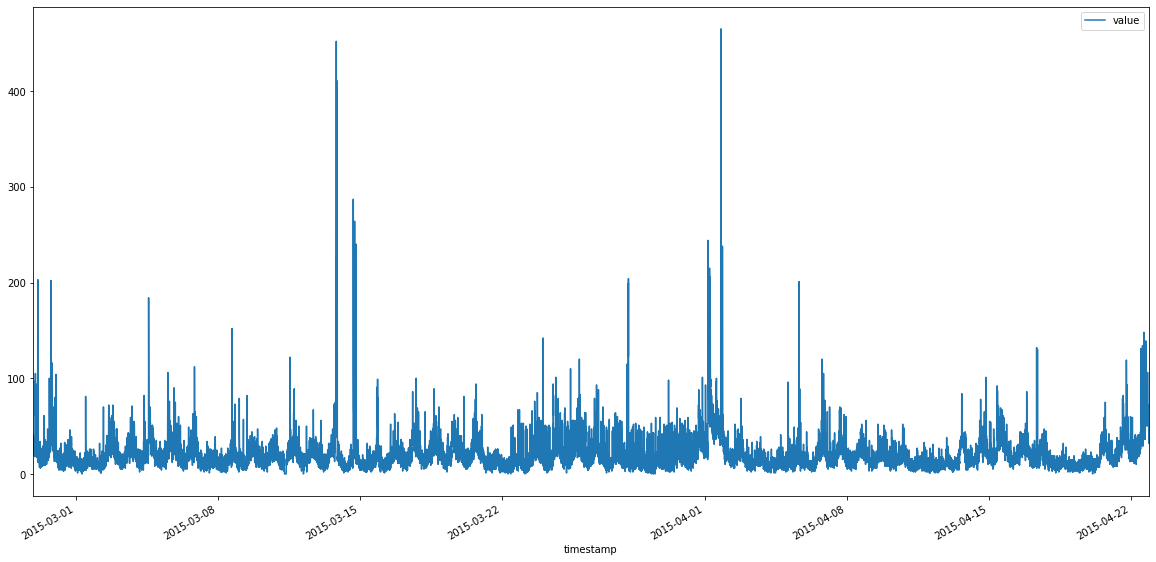

In [37]:
df.plot(x='timestamp', y='value', figsize=(20, 10));

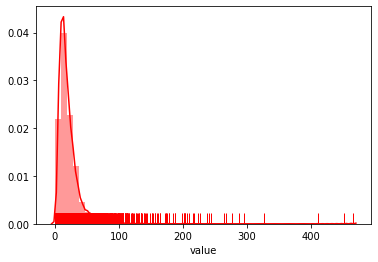

In [43]:
sns.distplot(df['value'], rug= True, color= 'Red', norm_hist=True)

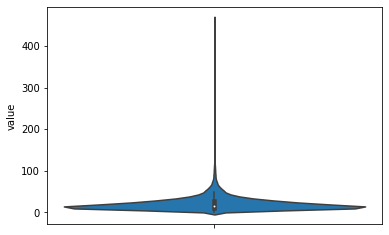

In [51]:
sns.violinplot(y='value',data=df, hue=df['timestamp'].dt.year,saturation=0.9, width=0.9)

# 
Now we will explore the data in more detail. We will dig in to time aspect of the data. We will split the timespan into four different columns: hour, day, week, month and year. 

Since the year is constant(in 2015), that does not say much. But, plots of value against months shows which months have higher values. Same holds for week and hour.  

In [124]:
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['week'] = df['timestamp'].dt.weekofyear
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year

In [60]:
df['hour'] = df['hour'].astype(np.float)

In [125]:
df.head()

,timestamp,value,hour,day,week,month,year
0,2015-02-26 21:42:53,35,21,26,9,2,2015
1,2015-02-26 21:47:53,41,21,26,9,2,2015
2,2015-02-26 21:52:53,32,21,26,9,2,2015
3,2015-02-26 21:57:53,36,21,26,9,2,2015
4,2015-02-26 22:02:53,32,22,26,9,2,2015


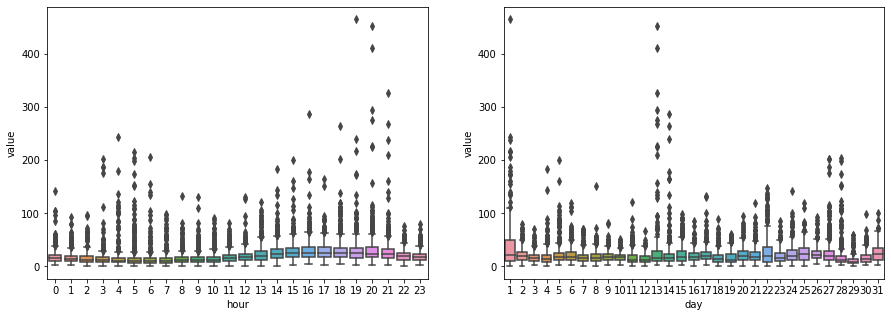

In [126]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.boxplot(x="hour", y="value", data=df, ax=ax[0])
sns.boxplot(x="day", y="value", data=df, ax=ax[1]);

#### Salient points:
The box plot above shows that there are some unusual number of values during the 20th and 21st hour of a day. 

Similarly, in the day plot, we see that there are number of outliers lying along 13th and 14th day of a month.

These 'anomalies' may help detect some unusual(possibly 'illegal') transactions, for example.

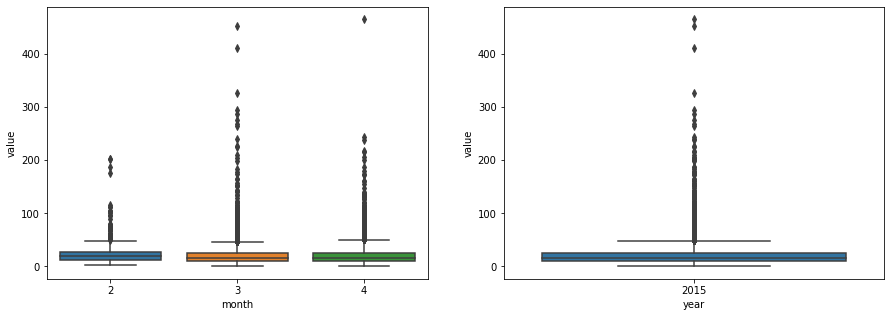

In [69]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.boxplot(x="month", y="value", data=df, ax=ax[0])
sns.boxplot(x="year", y="value", data=df, ax=ax[1]);

## Anomaly detection:
## Interquartile Range Method:
We will find the 5th-95th quantile of the data and any cases lying beyond this will be treated as anomalies. We have plotted a plot showing difference in the distribution. 


In [127]:
bound =  df['value'].quantile([0.05,0.95])
bound

0.05     5.0
0.95    50.0
Name: value, dtype: float64

In [128]:
true_index = (bound.loc[0.05] < df['value'].values) & (df['value'].values < bound.loc[0.95])
df['value'][true_index][:20]

0     35
1     41
2     32
3     36
4     32
5     25
6     33
7     20
8     38
9     28
10    28
11    27
12    30
13    31
14    38
15    35
16    33
17    24
18    28
19    20
Name: value, dtype: int64

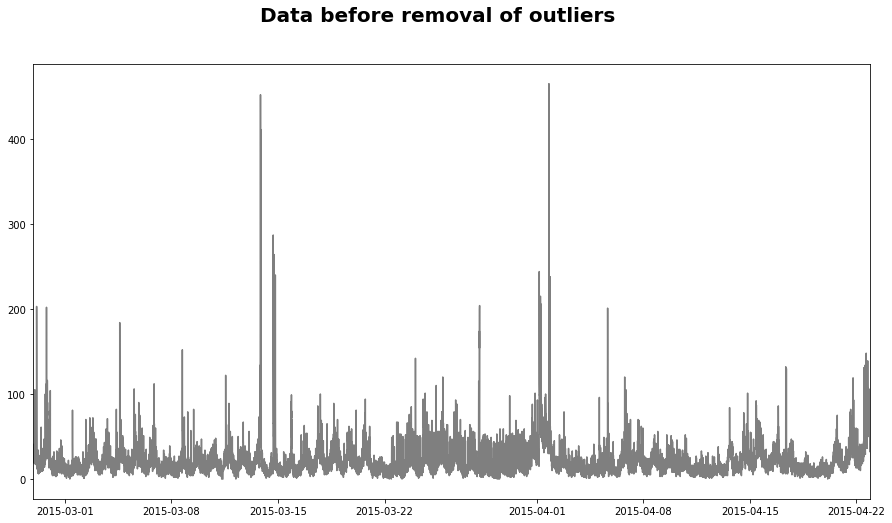

In [96]:
fig1=plt.figure(figsize=(15, 8))
fig1.suptitle('Data before removal of outliers', fontsize=20, fontweight='bold')
plt.plot(df['timestamp'], df['value'], c='k', alpha=0.5)
plt.xlim((df['timestamp'].min(), df['timestamp'].max()));

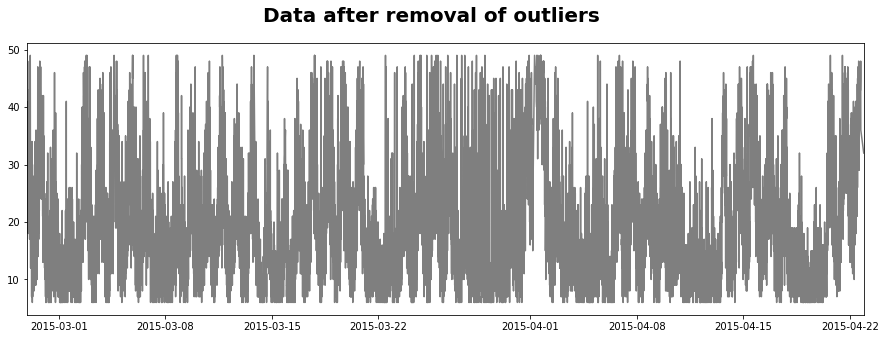

In [98]:
fig2=plt.figure(figsize=(15, 5))
fig2.suptitle('Data after removal of outliers', fontsize=20, fontweight='bold')
plt.plot(df['timestamp'][true_index], df['value'][true_index], c='k', alpha=0.5)
plt.xlim((df['timestamp'].min(), df['timestamp'].max()));

# Isolation Forest method:


In [101]:
#dropping timestamp and year predictors
dfw=df.drop(["timestamp","year"], axis=1)
dfw.head()

,value,hour,week,month,day
0,35,21.0,9,2,26
1,41,21.0,9,2,26
2,32,21.0,9,2,26
3,36,21.0,9,2,26
4,32,22.0,9,2,26


In [102]:
#fitting isolation forest model
from sklearn.ensemble import IsolationForest

model =  IsolationForest(contamination=0.05, behaviour='new')
model.fit(dfw)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

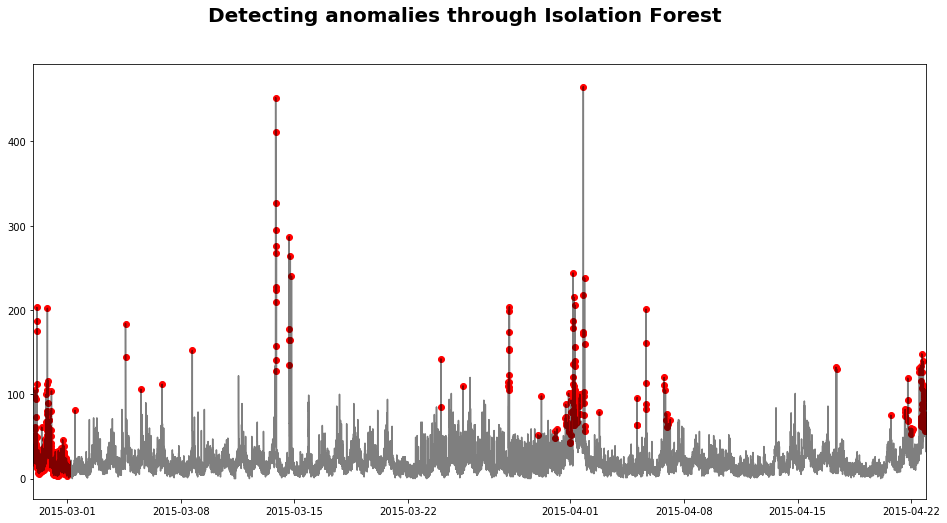

In [105]:
df['anomaly'] = model.predict(dfw)
fig3=plt.figure(figsize=(16, 8))
fig3.suptitle('Detecting anomalies through Isolation Forest', fontsize=20, fontweight='bold')
plt.plot(df['timestamp'], df['value'], c='k', alpha=0.5)
plt.scatter(df[df['anomaly']==-1]['timestamp'], df[df['anomaly']==-1]['value'], c='red')
plt.xlim((df['timestamp'].min(), df['timestamp'].max()));

# 
The red dots in the above plot are the anomalies. 

## DBSCAN Method:

In [107]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=1)
clusters = model.fit_predict(dfw)
df['cluster'] = clusters

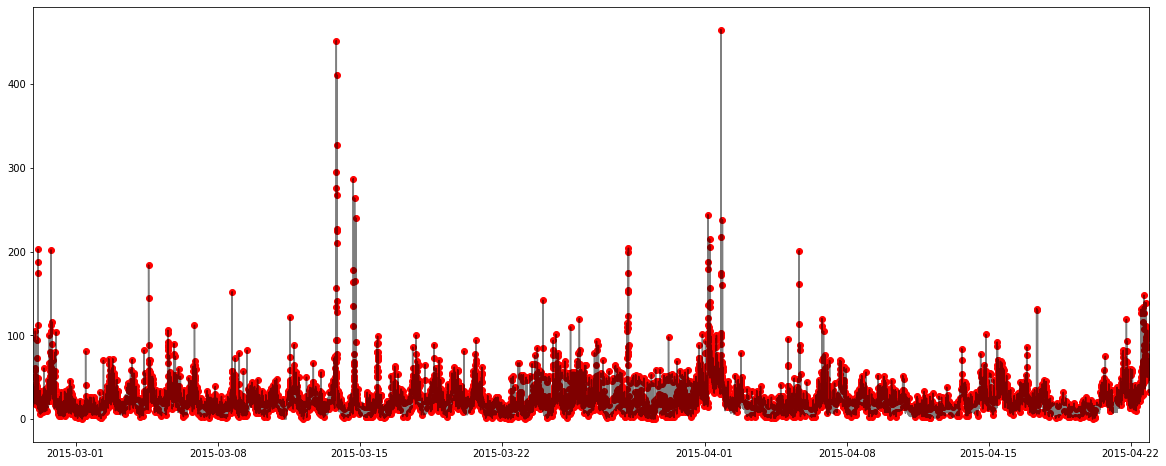

In [110]:
plt.figure(figsize=(20, 8))
plt.plot(df['timestamp'], df['value'], c='k', alpha=0.5)
plt.scatter(df[df['cluster']==-1]['timestamp'], df[df['cluster']==-1]['value'], c='red')
plt.xlim((df['timestamp'].min(), df['timestamp'].max()));

In [113]:
df['cluster'].value_counts()

-1      5137
 341     927
 302     893
 130     867
 88      747
 185     742
 29      735
 271     370
 282     195
 308     158
 96      154
 218     127
 393     125
 235     119
 91      118
 305     102
 360      97
 94       95
 23       82
 6        72
 310      72
 237      67
 86       66
 396      59
 347      59
 278      53
 24       52
 381      51
 48       49
 39       45
        ... 
 273       3
 300       3
 233       3
 255       3
 424       3
 313       3
 287       3
 356       3
 257       3
 280       3
 17        3
 377       3
 325       2
 368       2
 54        2
 277       2
 322       2
 395       2
 336       2
 102       2
 205       2
 112       2
 99        2
 334       2
 188       2
 81        2
 146       1
 114       1
 370       1
 204       1
Name: cluster, Length: 426, dtype: int64

# 
Clearly from the figure and the counts, DBSCAN method is showing more than 5000 cases are anomalies(out of 15k odd data). This is bit counter intuitive. We may conclude that it is not an effective outlier detection method for this data.

# Conclusion:

Anomaly detection is a crucial step in data analysis. For this data, we can apply other methods like knn and SVM methods. But, in the end we have to be judicious to brand some cases as anomalies. And that is the most difficult step usually. 